<a href="https://colab.research.google.com/github/gdnsjf/educational-work/blob/main/YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<IPython.core.display.Javascript object>

Saved to photo.jpg

0: 640x480 1 mouse, 1 keyboard, 199.7ms
Speed: 4.0ms preprocess, 199.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


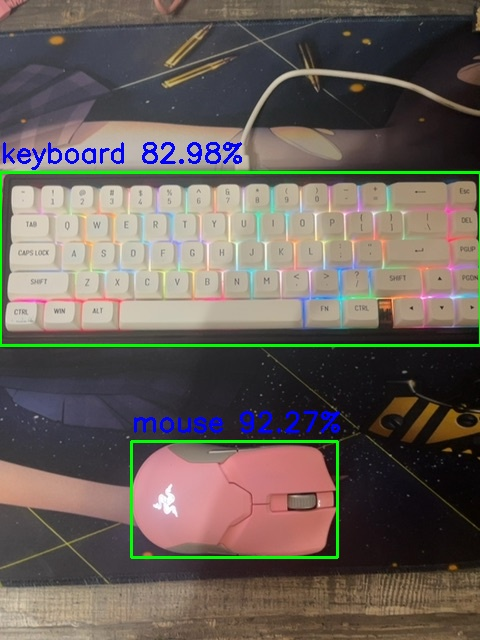

<IPython.core.display.Javascript object>

Saved to photo.jpg

0: 640x480 1 fork, 1 spoon, 1 dining table, 192.6ms
Speed: 3.2ms preprocess, 192.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


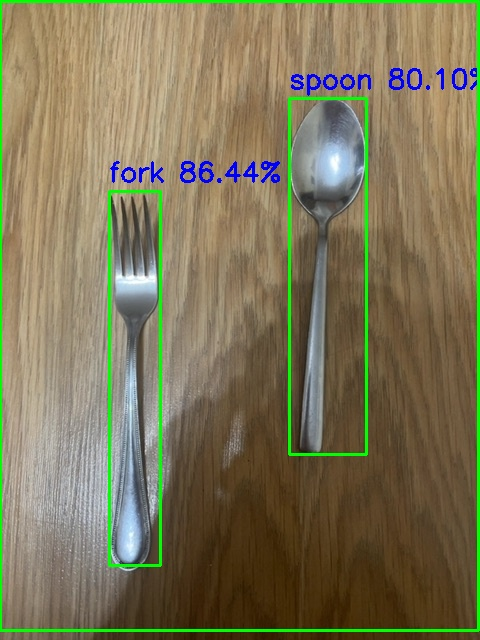

<IPython.core.display.Javascript object>

Saved to photo.jpg

0: 640x480 1 cup, 1 bowl, 200.8ms
Speed: 3.2ms preprocess, 200.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


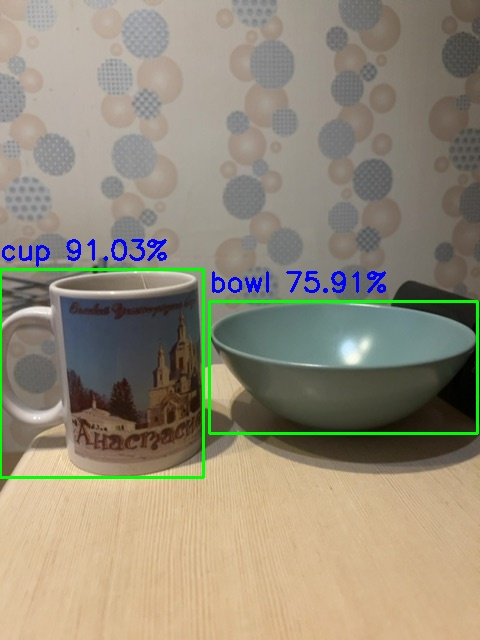

<IPython.core.display.Javascript object>

Остановлено пользователем.


In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
from ultralytics import YOLO
import cv2
import numpy as np

# Функция для захвата фото с основной камеры телефона
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const stopButton = document.createElement('button');
            stopButton.textContent = 'Stop';
            div.appendChild(stopButton);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({
                video: {
                    facingMode: { exact: "environment" }  // Выбор основной камеры
                }
            });

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture or Stop to be clicked.
            let takePhoto = new Promise((resolve) => capture.onclick = () => resolve("capture"));
            let stopPhoto = new Promise((resolve) => stopButton.onclick = () => resolve("stop"));

            let action = await Promise.race([takePhoto, stopPhoto]);

            if (action == "capture") {
                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);
                stream.getVideoTracks()[0].stop();
                div.remove();
                return canvas.toDataURL('image/jpeg', quality);
            } else {
                stream.getVideoTracks()[0].stop();
                div.remove();
                return null;
            }
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    if data:
        binary = b64decode(data.split(',')[1])
        with open(filename, 'wb') as f:
            f.write(binary)
        return filename
    else:
        return None

# Загружаем YOLOv8
model = YOLO('yolov8n.pt')

def process_image_with_yolo(filename):
    # Загружаем изображение
    img = cv2.imread(filename)

    # Применяем модель YOLOv8 к изображению
    results = model(img)

    # Рисуем рамочки и подписи
    for result in results[0].boxes:
        # Получаем координаты рамок
        x1, y1, x2, y2 = map(int, result.xyxy[0])
        label = model.names[int(result.cls)]
        confidence = result.conf[0] * 100

        # Рисуем рамку
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Добавляем подпись
        cv2.putText(img, f'{label} {confidence:.2f}%', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Сохраняем изображение
    annotated_filename = 'annotated_' + filename
    cv2.imwrite(annotated_filename, img)

    return annotated_filename

try:
    while True:
        # Захват фото с камеры
        filename = take_photo()
        if not filename:
            print("Остановлено пользователем.")
            break
        print('Saved to {}'.format(filename))

        # Обрабатываем изображение с помощью YOLOv8
        result_filename = process_image_with_yolo(filename)

        # Показать изображение с обнаруженными объектами
        display(Image(result_filename))

except Exception as err:
    print(str(err))
